# Оптимизация нейронных сетей. Метод обратного распространения ошибки (ноутбук)

> Узнаем как устроена оптимизация нейронных сетей. Оптимизация в `PyTorch`.

## План ноутбука

1. Высокоуровневое API для обучение нейросетей в `PyTorch`
2. Обучение первой нейросети в `PyTorch`

## Высокоуровневое API для обучение нейросетей в `PyTorch`

In [1]:
import torch
import torch.nn as nn

### Создание объекта нейросети

In [2]:
net = nn.Sequential(
    nn.Linear(700, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

In [3]:
net

Sequential(
  (0): Linear(in_features=700, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

In [4]:
from collections import OrderedDict

net = nn.Sequential(
    OrderedDict(
        [
            ('linear1', nn.Linear(700, 500)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(500, 200)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(200, 10))
        ]
    )
)

In [6]:
net.linear1

Linear(in_features=700, out_features=500, bias=True)

In [7]:
input_tensor = torch.rand(10, 700)

net(input_tensor).shape

torch.Size([10, 10])

In [8]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(700, 500)
        self.linear2 = nn.Linear(500, 200)
        self.linear3 = nn.Linear(200, 10)

        self.activation = nn.ReLU()

    def forward(self, x):
        output = self.activation(self.linear1(x))
        output = self.activation(self.linear2(output))
        output = self.linear3(output)

        return output

In [9]:
net = CustomTaskNetwork()

net(input_tensor).shape

torch.Size([10, 10])

In [10]:
net.to()

CustomTaskNetwork(
  (linear1): Linear(in_features=700, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
  (activation): ReLU()
)

In [11]:
net.train()
net.eval()

net.requires_grad_()

CustomTaskNetwork(
  (linear1): Linear(in_features=700, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
  (activation): ReLU()
)

In [21]:
net.parameters()

<generator object Module.parameters at 0x10a389510>

In [22]:
net.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0112,  0.0236,  0.0019,  ..., -0.0336, -0.0078, -0.0085],
                      [-0.0313, -0.0248,  0.0001,  ...,  0.0007, -0.0306,  0.0245],
                      [-0.0328, -0.0215, -0.0126,  ...,  0.0035,  0.0098,  0.0339],
                      ...,
                      [ 0.0306,  0.0347,  0.0028,  ...,  0.0022, -0.0008, -0.0056],
                      [-0.0140,  0.0285, -0.0127,  ...,  0.0286, -0.0233, -0.0319],
                      [ 0.0174,  0.0358, -0.0246,  ...,  0.0348, -0.0128, -0.0261]])),
             ('linear1.bias',
              tensor([ 2.9754e-02, -1.3126e-02,  1.4787e-02,  3.6148e-02, -1.1134e-02,
                       2.4818e-02, -1.9866e-02, -2.4699e-02, -6.3364e-04, -2.5510e-02,
                      -5.2723e-03,  2.7826e-03, -3.2614e-02, -3.5255e-02,  1.3799e-02,
                       2.8577e-02, -4.8262e-03,  3.5701e-02, -2.2522e-02,  2.6379e-03,
                      -1.1955e-02, -4.5398e-03,  2.6676e

In [23]:
net.load_state_dict(net.state_dict())

<All keys matched successfully>

### Оптимизаторы

In [24]:
from torch import optim

In [25]:
optim.SGD, optim.Adam

(torch.optim.sgd.SGD, torch.optim.adam.Adam)

In [26]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [27]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [28]:
optimizer = optim.SGD(
    [
        {'params': net.linear1.parameters()},
        {'params': net.linear2.parameters(), 'lr': 1e-3}
    ],
    lr=1e-2,
    momentum=0.9
)

In [29]:
optimizer.step()

In [30]:
optimizer.zero_grad()

### Функции потерь

In [31]:
nn.L1Loss, nn.MSELoss, nn.CrossEntropyLoss

(torch.nn.modules.loss.L1Loss,
 torch.nn.modules.loss.MSELoss,
 torch.nn.modules.loss.CrossEntropyLoss)

In [32]:
loss = nn.MSELoss()

In [33]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

output = loss(input, target)

print(output)

output.backward()

tensor(1.9623, grad_fn=<MseLossBackward0>)


In [34]:
input.grad

tensor([[-0.1863,  0.0963, -0.3480,  0.0311, -0.0168],
        [-0.1721,  0.1640, -0.2355, -0.1563, -0.1045],
        [-0.2076,  0.0515, -0.2527,  0.0228, -0.3155]])

### Датасеты и даталоадеры

In [36]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

In [37]:
n_features = 2
n_objects = 300

torch.manual_seed(0);

In [38]:
w_true = torch.randn(n_features)

X = (torch.rand(n_objects, n_features) - 0.5) * 10
X *= (torch.arange(n_features) * 2 + 1)
Y = (X @ w_true + torch.randn(n_objects)).unsqueeze(1)

In [39]:
dataset = TensorDataset(X, Y)

In [43]:
dataset[7]

(tensor([-3.3897, -6.5319]), tensor([-3.7483]))

In [42]:
X[7], Y[7]

(tensor([-3.3897, -6.5319]), tensor([-3.7483]))

In [44]:
class CustomDataset(Dataset):
    def __init__(self, w_true, n_features, n_objects):
        self.X = (torch.rand(n_objects, n_features) - 0.5) * 10
        self.X *= (torch.arange(n_features) * 2 + 1)
        self.Y = self.X @ w_true + torch.randn(n_objects)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        return self.X[item], self.Y[item]

In [45]:
dataset = CustomDataset(w_true, n_features, n_objects)

In [48]:
from torch.utils.data import DataLoader

In [49]:
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [54]:
for x, y in loader:
    print(x.shape)

torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([

In [51]:
X.shape

torch.Size([300, 2])

### Общая структура обучения модели

model.train()

for x, y in dataloader:

    optimizer.zero_grad()

    output = model(x)

    loss = loss_fn(output, y)

    loss.backward()

    optimizer.step()

## Обучение первой нейросети в `PyTorch`

In [63]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

loss_fn = nn.MSELoss()

dataset = TensorDataset(X, Y)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

w_list = torch.empty(len(loader) + 1, n_features)

In [64]:
net.train()

for i, (x, y) in enumerate(loader):
    w_list[i] = net.linear.weight.detach().clone()

    optimizer.zero_grad()

    output = net(x)

    loss = loss_fn(output, y)

    print(f'MSE на шаге {i} {loss.item():.5f}')

    loss.backward()

    optimizer.step()

w_list[len(loader)] = net.linear.weight.detach().clone()

MSE на шаге 0 26.19419
MSE на шаге 1 21.36962
MSE на шаге 2 72.87616
MSE на шаге 3 60.03906
MSE на шаге 4 8.88771
MSE на шаге 5 30.41561
MSE на шаге 6 9.93647
MSE на шаге 7 8.02992
MSE на шаге 8 18.51692
MSE на шаге 9 3.50421
MSE на шаге 10 6.23041
MSE на шаге 11 5.03649
MSE на шаге 12 2.36526
MSE на шаге 13 9.67055
MSE на шаге 14 1.16297
MSE на шаге 15 0.65199
MSE на шаге 16 6.95910
MSE на шаге 17 1.41618
MSE на шаге 18 2.11158
MSE на шаге 19 4.88758
MSE на шаге 20 12.11743
MSE на шаге 21 6.28058
MSE на шаге 22 3.83081
MSE на шаге 23 4.83289
MSE на шаге 24 3.57723
MSE на шаге 25 5.58337
MSE на шаге 26 0.83595
MSE на шаге 27 1.14049
MSE на шаге 28 0.83483
MSE на шаге 29 1.73279
MSE на шаге 30 5.10439
MSE на шаге 31 0.95391
MSE на шаге 32 1.75330
MSE на шаге 33 1.10862
MSE на шаге 34 1.73119
MSE на шаге 35 0.33786
MSE на шаге 36 6.48447
MSE на шаге 37 2.83668
MSE на шаге 38 2.39993
MSE на шаге 39 0.66318
MSE на шаге 40 2.13568
MSE на шаге 41 1.04859
MSE на шаге 42 0.81732
MSE на шаге 43

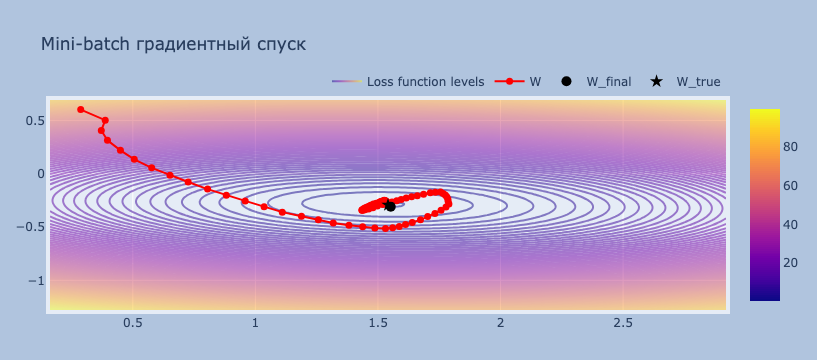

In [65]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)

In [75]:
num_epochs = 5

w_list = torch.empty(len(loader) * num_epochs + 1, n_features)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

In [76]:
net.train()

for epoch in range(num_epochs):
    total_loss = 0

    for i, (x, y) in enumerate(loader):
        w_list[i + epoch * len(loader)] = net.linear.weight.detach().clone()

        optimizer.zero_grad()

        output = net(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        loss.backward()

        optimizer.step()

    total_loss /= len(loader)

    print(f'MSE после эпохи {epoch} {total_loss:.5f}')

w_list[len(loader) * num_epochs] = net.linear.weight.detach().clone()

MSE после эпохи 0 3.36680
MSE после эпохи 1 1.11715
MSE после эпохи 2 1.12583
MSE после эпохи 3 1.26559
MSE после эпохи 4 1.11840


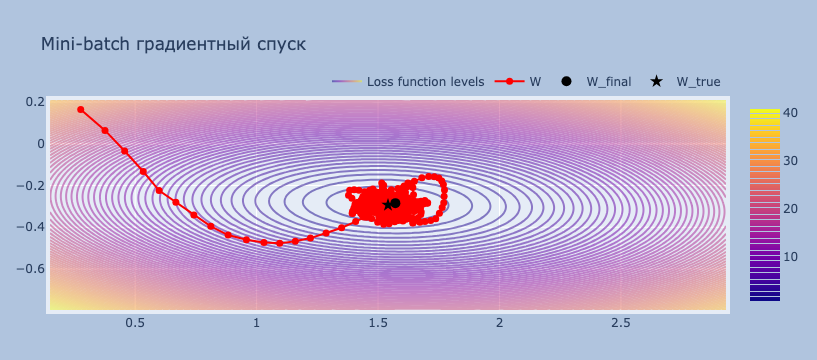

In [77]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)